In [37]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline                          
sns.set(color_codes=True)                   

In [38]:
import os
# excel_file_path = os.path.join(os.getcwd(), 'price_history.xlsx')
# df_xlsx = pd.read_excel(excel_file_path)
csv_file_path = os.path.join(os.getcwd(), 'data_csv_file.csv')
# df_xlsx.to_csv(csv_file_path, index=False)
df = pd.read_csv(csv_file_path)
print(df.head())

         Exchange Date    Close    Net      %Chg     Open      Low     High
0  2024-04-22 00:00:00  1067.81   5.08  0.004780  1063.63  1061.95  1069.61
1  2024-04-19 00:00:00  1062.73 -15.16 -0.014065  1077.39  1054.16  1077.51
2  2024-04-18 00:00:00  1077.89   3.02  0.002810  1076.24  1072.81  1083.88
3  2024-04-17 00:00:00  1074.87   3.81  0.003557  1070.80  1070.46  1076.86
4  2024-04-16 00:00:00  1071.06 -20.72 -0.018978  1091.60  1070.13  1091.64


In [39]:
df['Exchange Date'] = pd.to_datetime(df['Exchange Date'], errors='coerce') # Transforming data in timestamps.
df = df.dropna(subset=['Exchange Date']) # Removing invalid dates. (such as 30th feb)

In [40]:
print(df.shape)

(941, 7)


In [41]:
duplicate_rows_df = df[df.duplicated()] 
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (1, 7)


In [42]:
df = df.drop_duplicates(keep='last') # Removing duplicate rows.
print(df.shape)

(940, 7)


!Check if any dates are missing below!. // (should check if weekdays are included)

In [43]:
daily_data = pd.DataFrame(pd.date_range(start=df['Exchange Date'].min(),end=df['Exchange Date'].max()))
daily_data.rename(columns={ daily_data.columns[0]: "Date" }, inplace = True)
daily_data.describe()

,Date
count,1315
mean,2022-07-05 00:00:00
min,2020-09-16 00:00:00
25%,2021-08-10 12:00:00
50%,2022-07-05 00:00:00
75%,2023-05-29 12:00:00
max,2024-04-22 00:00:00


# EDA

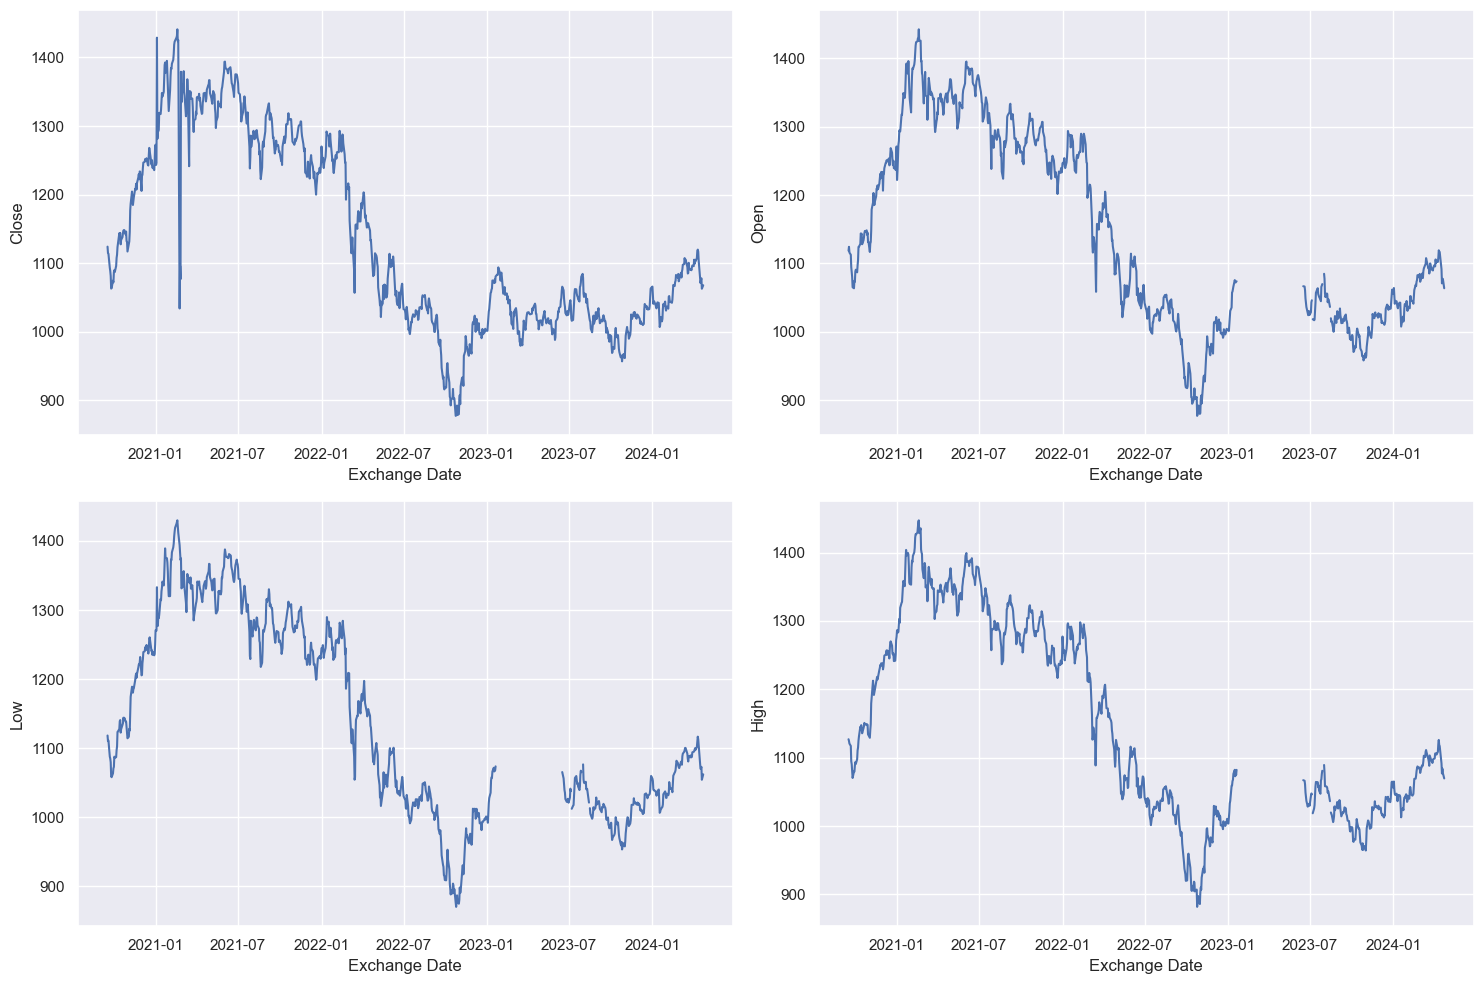

In [44]:
columns_to_plot = ['Close', 'Open', 'Low', 'High']
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    plt.plot(df['Exchange Date'], df[column])
    plt.xlabel('Exchange Date')
    plt.ylabel(column)  
plt.tight_layout()  
plt.show()

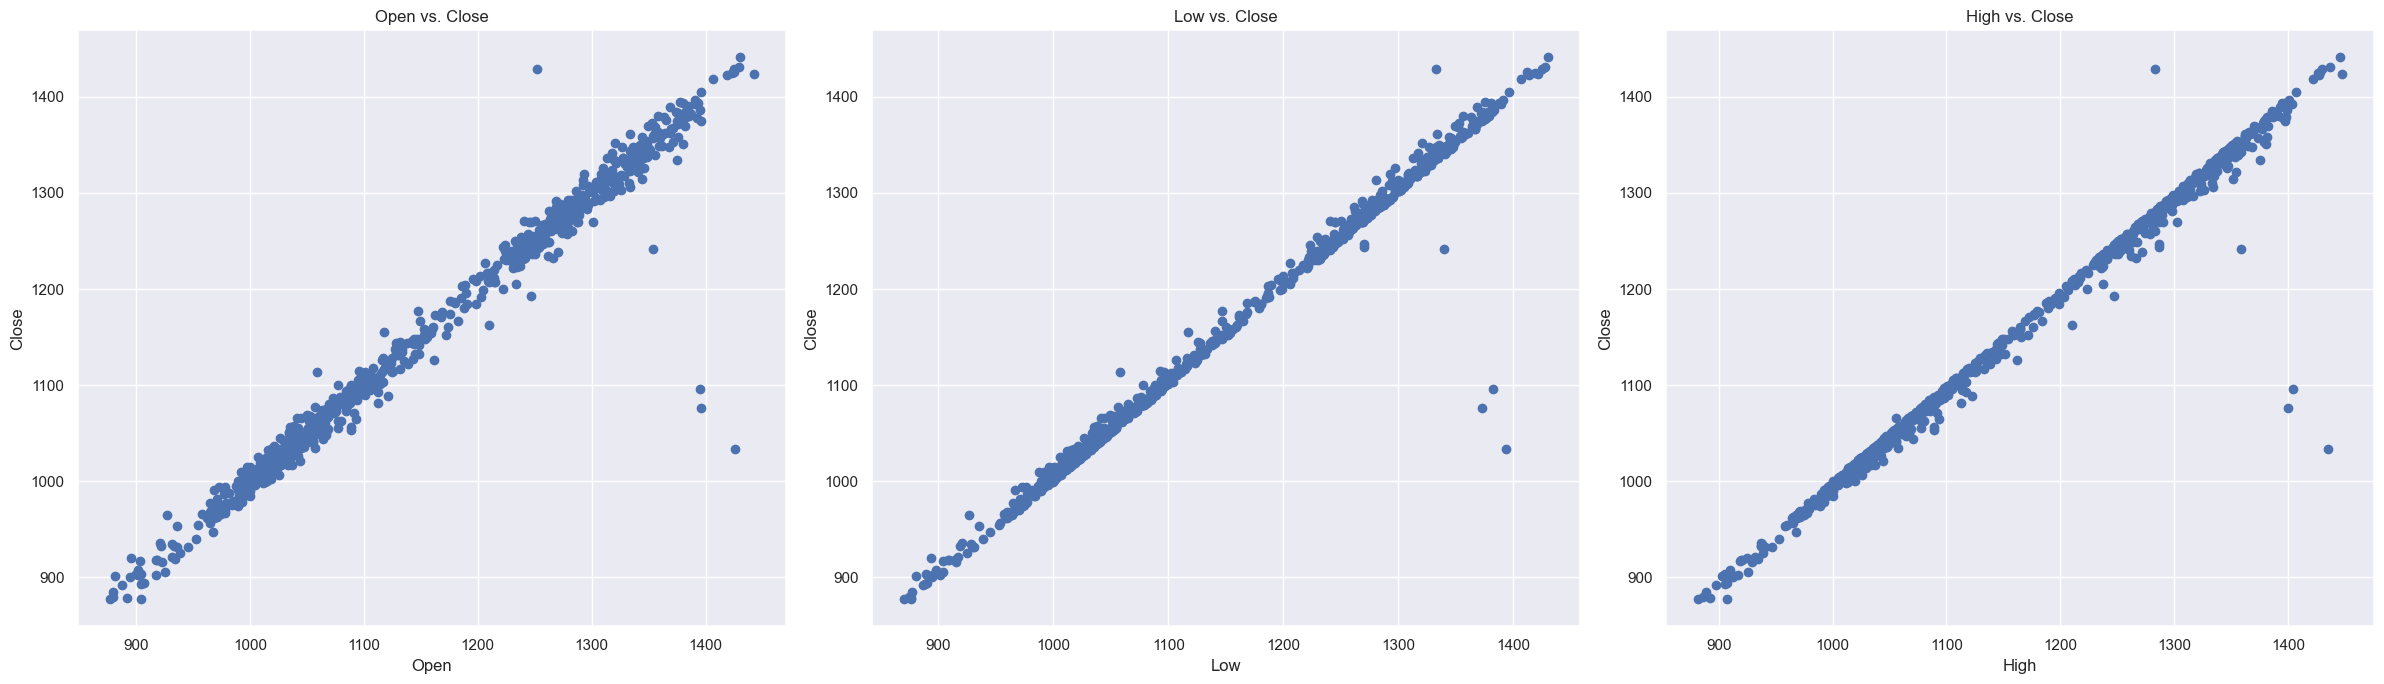

In [45]:
columns_to_plot = ['Open', 'Low', 'High']

# Create a figure and subplots using a for loop
fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(24, 7))

for col, ax in zip(columns_to_plot, axes):
    ax.scatter(df[col], df['Close'])
    ax.set_xlabel(col)
    ax.set_ylabel('Close')
    ax.set_title(f'{col} vs. Close')

plt.tight_layout()
plt.show()

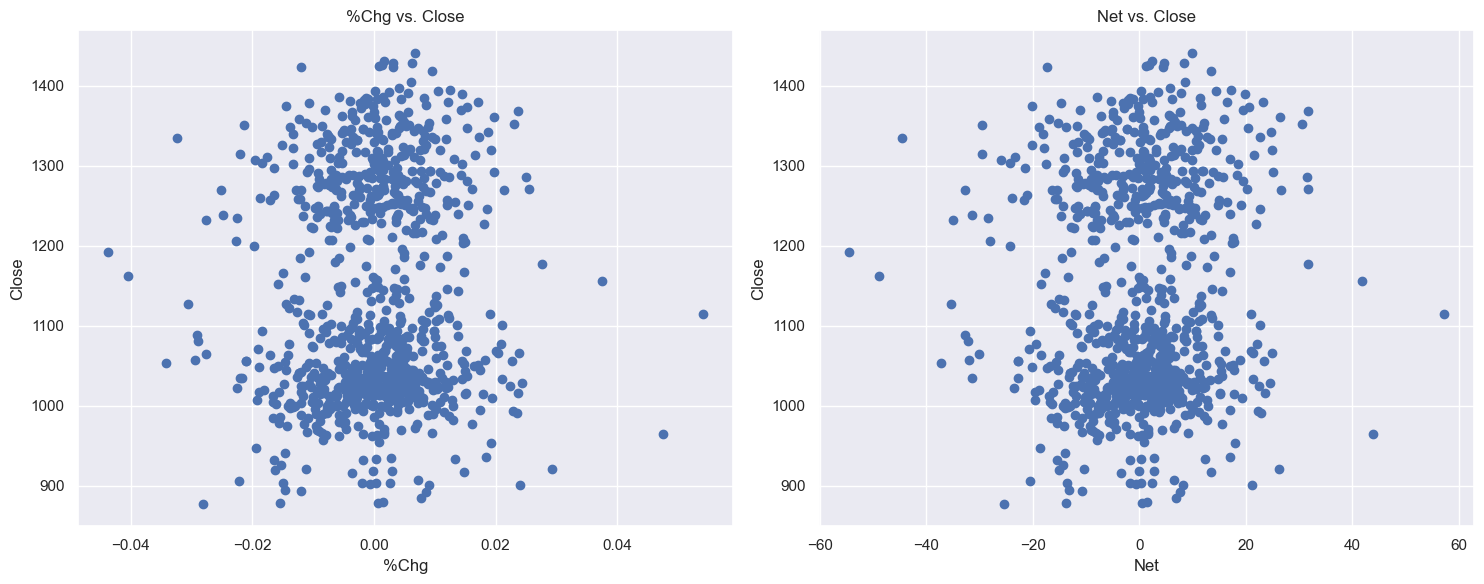

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.scatter(df['%Chg'], df['Close'])
ax1.set_xlabel('%Chg')
ax1.set_ylabel('Close')
ax1.set_title('%Chg vs. Close') 

ax2.scatter(df['Net'], df['Close'])
ax2.set_xlabel('Net')
ax2.set_ylabel('Close')
ax2.set_title('Net vs. Close') 

plt.tight_layout()
plt.show()

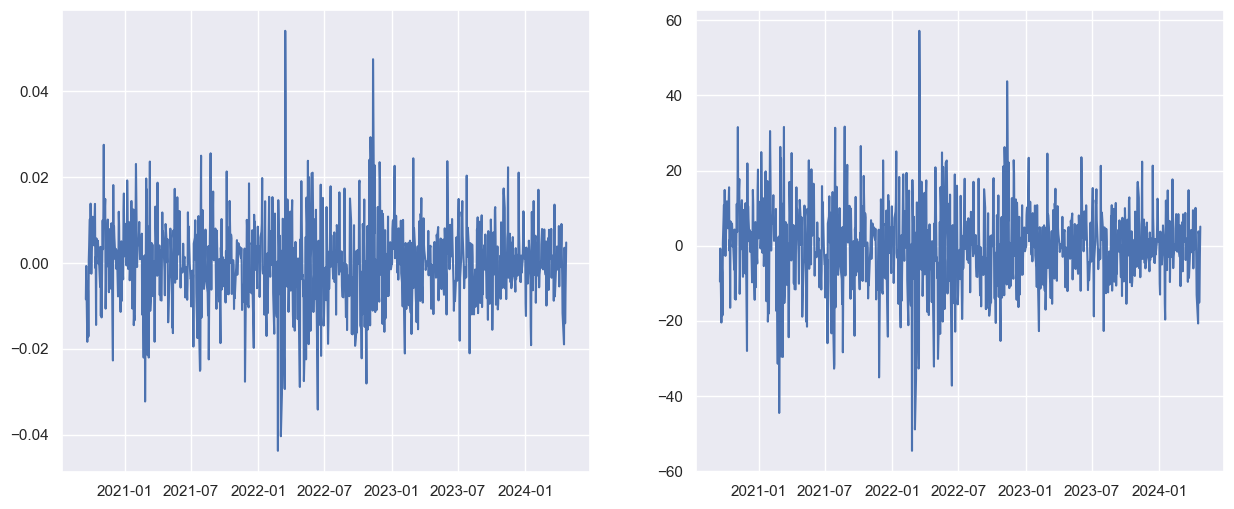

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(df['Exchange Date'], df['%Chg'])
ax2.plot(df['Exchange Date'], df['Net'])
plt.show()

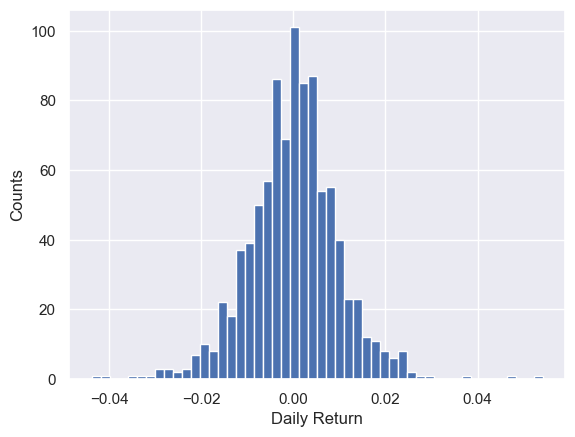

In [48]:
plt.hist(df['%Chg'], bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.show()

## Outliers

Visualizing the outliers:

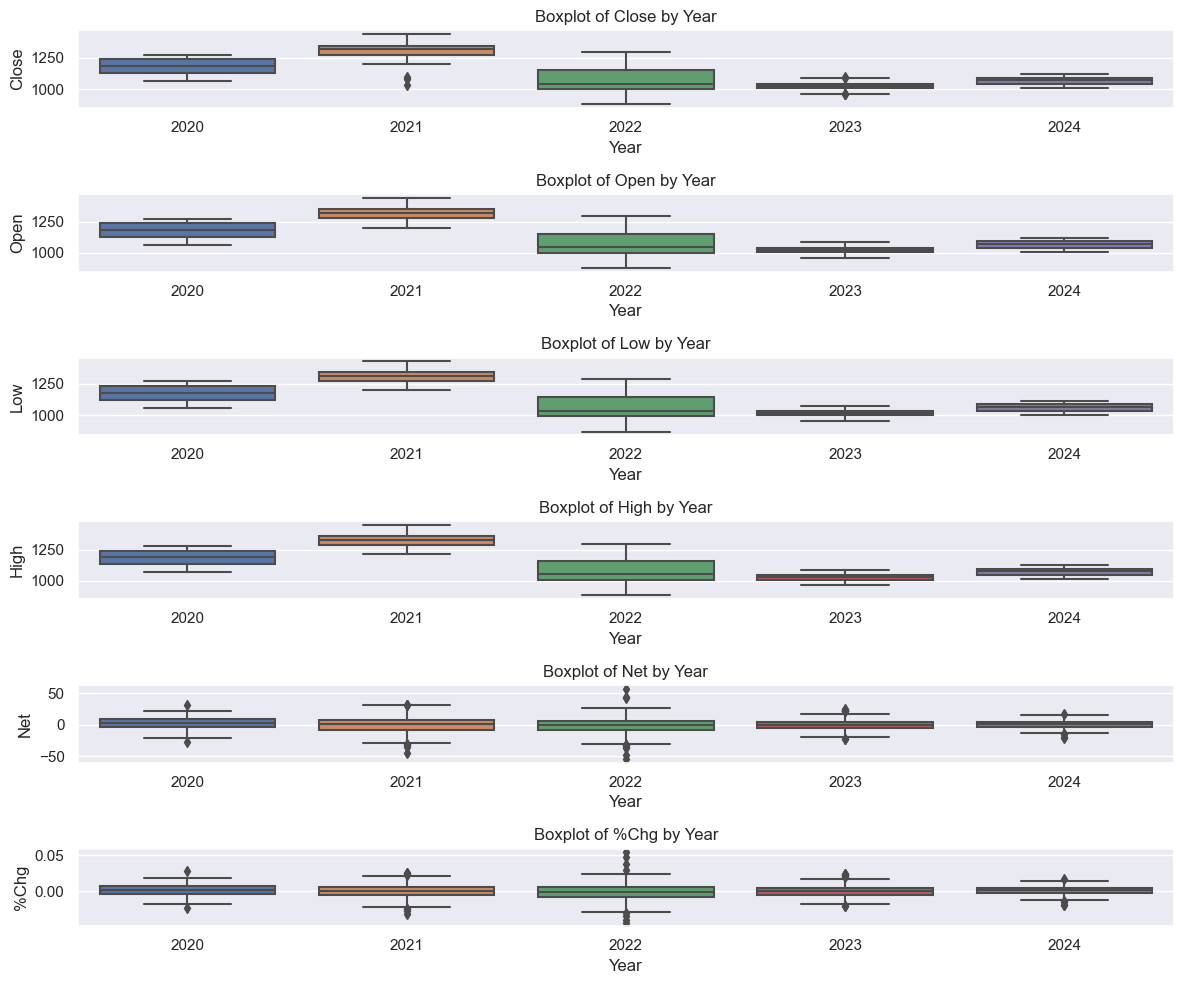

In [24]:
df['Year'] = df['Exchange Date'].dt.year
years = df['Year'].unique()
columns_to_plot = ['Close', 'Open', 'Low', 'High', 'Net', '%Chg']

fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(12, 10))

for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    ax.set_title(f"Boxplot of {column} by Year")
    sns.boxplot(x="Year", y=column, data=df, ax=ax)

plt.tight_layout()
plt.show()

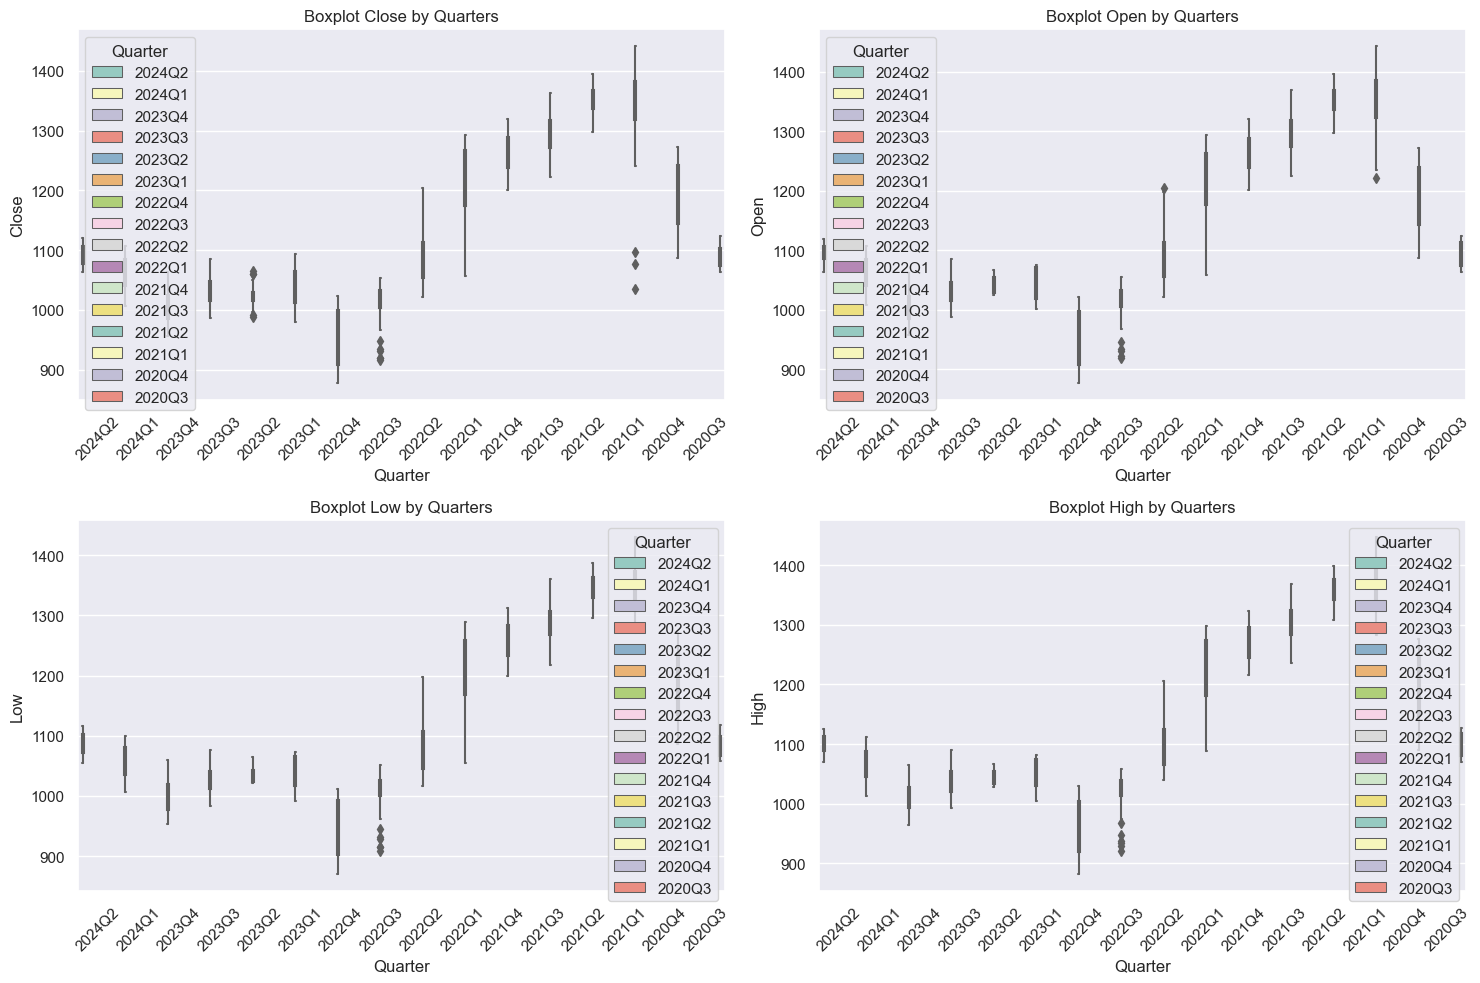

In [17]:
df['Quarter'] = df['Exchange Date'].dt.to_period('Q')
columns_to_plot = ['Close', 'Open', 'Low', 'High']
plt.figure(figsize=(15, 10))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Quarter', y=column, data=df, palette='Set3', hue = 'Quarter')
    plt.title(f'Boxplot {column} by Quarters')
    plt.xlabel('Quarter')
    plt.ylabel(column)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Corelation matrix

C:\Users\anaro\miniconda3\envs\lseg\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


,Exchange Date,Close,Net,%Chg,Open,Low,High
Exchange Date,1.000000,-0.747079,-0.014333,-0.012067,-0.733376,-0.731095,-0.738291
Close,-0.747079,1.000000,0.057873,0.054537,0.984914,0.988776,0.987114
Net,-0.014333,0.057873,1.000000,0.992462,-0.035806,0.011220,0.004282
%Chg,-0.012067,0.054537,0.992462,1.000000,-0.036541,0.009363,0.003908
Open,-0.733376,0.984914,-0.035806,-0.036541,1.000000,0.998146,0.998621
Low,-0.731095,0.988776,0.011220,0.009363,0.998146,1.000000,0.998551
High,-0.738291,0.987114,0.004282,0.003908,0.998621,0.998551,1.000000


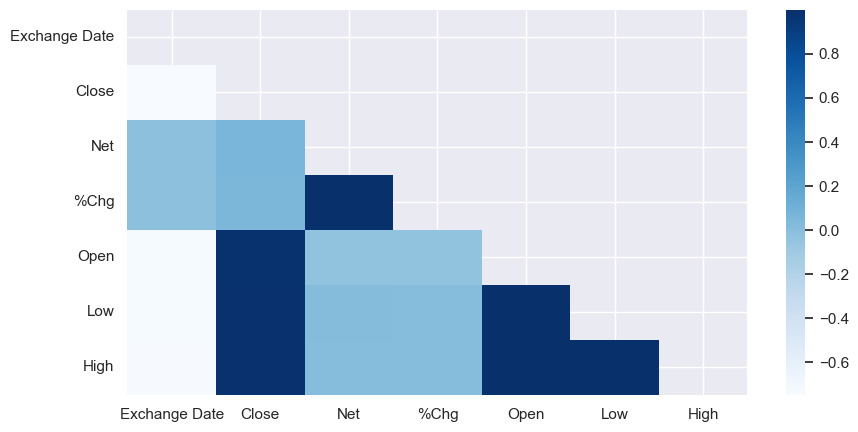

In [49]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10,5))
sns.heatmap(corr, cmap="Blues", annot=True, mask = mask)
corr